# IMPORT LIBRARY

In [63]:
import os
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.random import set_seed

from lstm import LSTM_from_Scratch

In [64]:
set_seed(42)
np.random.seed(42)
random.seed(42)

In [65]:
sns.set_theme(style="whitegrid", palette="pastel")

# IMPORT DATASETS

In [66]:
df_train = pd.read_csv('https://drive.google.com/uc?id=1qOIeJsdYDd40AHEWJsvAvvrziYSb1Dfk')
df_val = pd.read_csv('https://drive.google.com/uc?id=1qMkR0WU_O_moKFRDkVdfOqaiau636nWY')
df_test = pd.read_csv('https://drive.google.com/uc?id=1qM2vuX3_cuqdw_URoxpUnwE1Tk_SJV97')

# EDA

In [67]:
df_train.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [68]:
df_val.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,neutral
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,negative
2,556,"Minimal cek pesan saya, ada problem yang rumit...",neutral
3,474,Dulu restoran ini merupakan favorit saya karen...,negative
4,42,Merupakan resto vintage dengan harga yang cuku...,positive


In [69]:
df_test.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
1,729,"Iya benar, dia sedang jaga warung.",neutral
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
3,262,Bertempat di braga city walk yang satu gedung ...,positive
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [70]:
print(f'df_train shape: {df_train.shape}')
print(f'df_val shape: {df_val.shape}')
print(f'df_test shape: {df_test.shape}')

df_train shape: (500, 3)
df_val shape: (100, 3)
df_test shape: (400, 3)


# PREPROCESS

In [71]:
class TextPreprocessor:
    def __init__(self,
                 text_col='text',
                 label_col='label',
                 max_words=10000,
                 max_len=100,
                 embedding_dim=100,
                 embedding_path='glove.6B.100d.txt'):
        self.text_col = text_col
        self.label_col = label_col
        self.max_words = max_words
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.embedding_path = embedding_path

        self.tokenizer = None
        self.embedding_matrix = None
        self.label_map = {'neutral': 1, 'positive': 2, 'negative': 0}
        self.fitted = False

    def fit(self, df):
        self.tokenizer = Tokenizer(num_words=self.max_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(df[self.text_col].astype(str))

        if self.embedding_path:
            embeddings_index = {}
            with open(self.embedding_path, encoding='utf-8') as f:
                for line in f:
                    values = line.split()
                    word = values[0]
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
            word_index = self.tokenizer.word_index
            num_words = min(self.max_words, len(word_index) + 1)
            self.embedding_matrix = np.zeros((num_words, self.embedding_dim))
            for word, i in word_index.items():
                if i >= self.max_words:
                    continue
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    self.embedding_matrix[i] = embedding_vector
        self.fitted = True
        return self

    def transform(self, df):
        if not self.fitted:
            raise ValueError("TextPreprocessor must be fitted before calling transform.")

        y = df[self.label_col].map(self.label_map).values if self.label_col in df else None
        sequences = self.tokenizer.texts_to_sequences(df[self.text_col].astype(str))
        X = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return X, y

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

    def get_tokenizer(self):
        return self.tokenizer

    def get_embedding_matrix(self):
        return self.embedding_matrix

In [72]:
preprocessor = TextPreprocessor(text_col='text', label_col='label')
df_train_preprocessed = preprocessor.fit_transform(df_train)
df_val_preprocessed = preprocessor.transform(df_val)
df_test_preprocessed = preprocessor.transform(df_test)

In [73]:
df_train_preprocessed

(array([[1152,  736,  737, ...,    0,    0,    0],
        [ 295,  295,    2, ...,    0,    0,    0],
        [ 359,  151,  443, ...,    0,    0,    0],
        ...,
        [ 117,    5, 2780, ...,    0,    0,    0],
        [2786,   54,  214, ...,    0,    0,    0],
        [  91,   91,    3, ...,    0,    0,    0]]),
 array([1, 2, 1, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2,
        2, 0, 1, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2,
        0, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 2,
        1, 1, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1,
        2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 0, 1, 2, 0,
        1, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 1, 0,
        2, 0, 1, 2, 1, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 2, 0, 0, 1,
        1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 2, 0, 0, 2, 0, 1,
        2, 2, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 2, 2,
        2, 0,

# MODELLING

## IMPORT LIBRARIES

## DEFINE FUNCTIONS

In [74]:
epsilon = 1e-7
n_samples = len(df_val)

max_loss_per_sample = -np.log(epsilon)
max_total_loss = n_samples * max_loss_per_sample

print(f"Max possible loss per sample: {max_loss_per_sample:.2f}")
print(f"Max possible loss for {n_samples} samples: {max_total_loss:.2f}")


Max possible loss per sample: 16.12
Max possible loss for 100 samples: 1611.81


In [75]:
def plot_training_history(history, acc_key='accuracy', val_acc_key='val_accuracy',
                         loss_key='loss', val_loss_key='val_loss', title='Training History'):
    sns.set(style='whitegrid')
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history[acc_key]) + 1),
                 y=history.history[acc_key], label='Train Accuracy', marker='o')
    sns.lineplot(x=range(1, len(history.history[val_acc_key]) + 1),
                 y=history.history[val_acc_key], label='Validation Accuracy', marker='s')
    plt.title('Model Accuracy', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()

    # Loss
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history[loss_key]) + 1),
                 y=history.history[loss_key], label='Train Loss', marker='o')
    sns.lineplot(x=range(1, len(history.history[val_loss_key]) + 1),
                 y=history.history[val_loss_key], label='Validation Loss', marker='s')
    plt.title('Model Loss', fontsize=14, weight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.ylim(0, 1.25)
    plt.legend()
    plt.tight_layout()

    plt.suptitle(title, fontsize=16, weight='bold', y=1.03)
    plt.show()


## DEFINE GLOBAL VARIABLE

In [76]:
max_words = preprocessor.max_words
max_len = preprocessor.max_len
embedding_dim = preprocessor.embedding_dim
embedding_matrix = preprocessor.get_embedding_matrix()
actual_vocab_size = len(preprocessor.get_tokenizer().word_index) + 1
EPOCH = 50

In [77]:
X_train, y_train = df_train_preprocessed
X_val, y_val = df_val_preprocessed

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### Layers

#### 2 Layers LSTM

In [78]:
model_lstm_2_layers = Sequential()

model_lstm_2_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_2_layers.add(SpatialDropout1D(0.2))
model_lstm_2_layers.add(LSTM(64, return_sequences=True))
model_lstm_2_layers.add(LSTM(64))
model_lstm_2_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [79]:
model_lstm_2_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_2_layers = model_lstm_2_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3570 - loss: 1.0948 - val_accuracy: 0.3800 - val_loss: 1.0815
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3981 - loss: 1.0756 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3889 - loss: 1.0685 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3889 - loss: 1.0723 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3889 - loss: 1.0710 - val_accuracy: 0.3800 - val_loss: 1.0772
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.3905 - loss: 1.0670 - val_accuracy: 0.4800 - val_loss: 1.0553
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4432 - loss: 1.0480 - val_accuracy: 0.3700 - val_loss: 1.0769
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4095 - loss: 1.0741 - val_accuracy: 0.3800 - val_loss: 1.0837

In [80]:
model_lstm_2_layers.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,979 (1.93 MB)

 Trainable params: 75,459 (294.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 150,920 (589.54 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Validation Loss: 0.8826
Validation Accuracy: 0.6300
Validation Macro F1-score: 0.6026
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test Loss: 0.8862
Test Accuracy: 0.6575
Test Macro F1-score: 0.6445


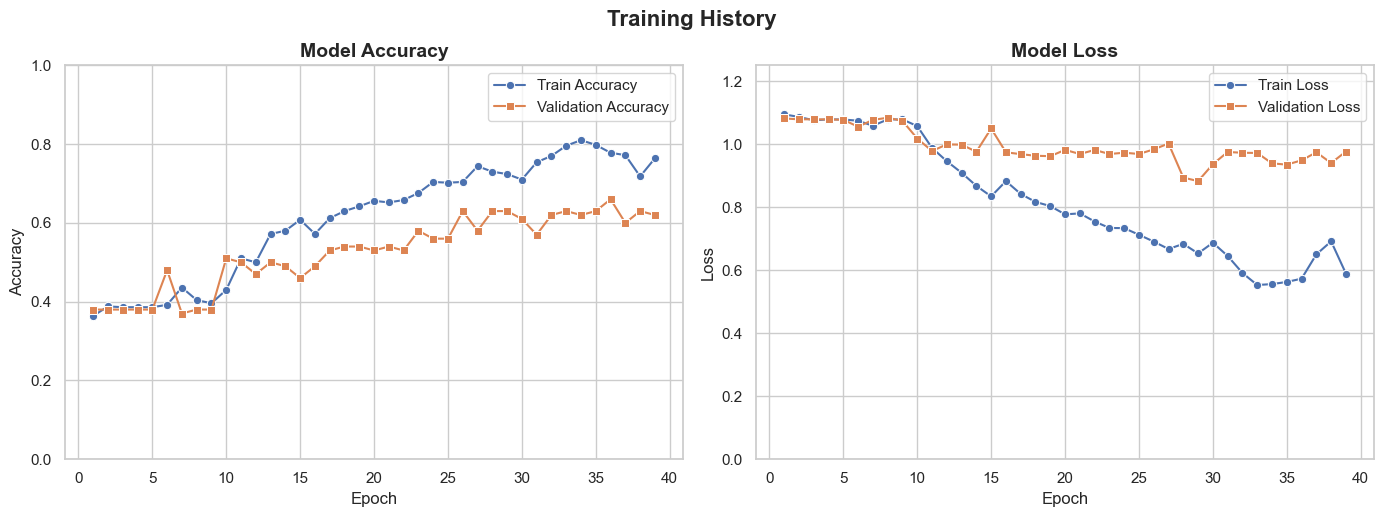

In [81]:
loss, accuracy = model_lstm_2_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_2_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_2_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_2_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [82]:
model_lstm_2_layers.save(f'models/lstm_model_2_layers.h5')

#### 4 Layers LSTM

In [83]:
model_lstm_4_layers = Sequential()

model_lstm_4_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_4_layers.add(SpatialDropout1D(0.2))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64, return_sequences=True))
model_lstm_4_layers.add(LSTM(64))
model_lstm_4_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [84]:
model_lstm_4_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_4_layers = model_lstm_4_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.3078 - loss: 1.0931 - val_accuracy: 0.3800 - val_loss: 1.0767
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.3882 - loss: 1.0695 - val_accuracy: 0.3800 - val_loss: 1.0729
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.3972 - loss: 1.0547 - val_accuracy: 0.4700 - val_loss: 1.0315
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5031 - loss: 1.0121 - val_accuracy: 0.4500 - val_loss: 0.9878
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.5152 - loss: 0.9522 - val_accuracy: 0.4500 - val_loss: 1.0018
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5502 - loss: 0.9178 - val_accuracy: 0.4800 - val_loss: 0.9760
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5610 - loss: 0.8752 - val_accuracy: 0.5000 - val_loss: 0.9915
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5869 - loss: 0.8537 - val_accuracy: 0.5100 - val_loss: 

In [85]:
model_lstm_4_layers.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_9             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,123 (2.69 MB)

 Trainable params: 141,507 (552.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 283,016 (1.08 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Validation Loss: 0.8895
Validation Accuracy: 0.6200
Validation Macro F1-score: 0.6054
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test Loss: 0.8723
Test Accuracy: 0.6275
Test Macro F1-score: 0.6063


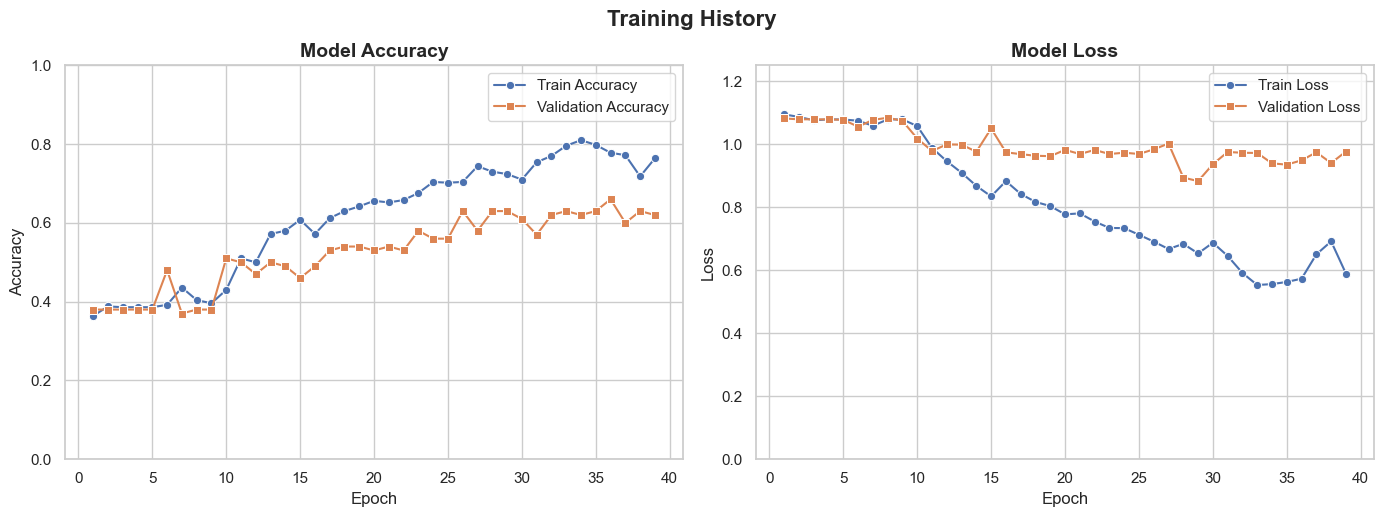

In [86]:
loss, accuracy = model_lstm_4_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_4_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_4_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_4_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [87]:
model_lstm_4_layers.save(f'models/lstm_model_4_layers.h5')

#### 8 Layers LSTM

In [88]:
model_lstm_8_layers = Sequential()

model_lstm_8_layers.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_8_layers.add(SpatialDropout1D(0.2))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64, return_sequences=True))
model_lstm_8_layers.add(LSTM(64))
model_lstm_8_layers.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [89]:
model_lstm_8_layers.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_8_layers = model_lstm_8_layers.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.3966 - loss: 1.0935 - val_accuracy: 0.5000 - val_loss: 1.0495
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4917 - loss: 1.0265 - val_accuracy: 0.4700 - val_loss: 0.9657
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5161 - loss: 0.9428 - val_accuracy: 0.4800 - val_loss: 0.9918
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5623 - loss: 0.8831 - val_accuracy: 0.4900 - val_loss: 0.9686
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5949 - loss: 0.8531 - val_accuracy: 0.5200 - val_loss: 0.9487
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.6134 - loss: 0.8299 - val_accuracy: 0.5100 - val_loss: 1.0034
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5855 - loss: 0.8494 - val_accuracy: 0.5100 - val_loss: 1.0152
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.6159 - loss: 0.8247 - val_accuracy: 0.5500 - val_loss

In [90]:
model_lstm_8_layers.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,100,411 (4.20 MB)

 Trainable params: 273,603 (1.04 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 547,208 (2.09 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step
Validation Loss: 0.9487
Validation Accuracy: 0.5200
Validation Macro F1-score: 0.4934
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Test Loss: 0.9283
Test Accuracy: 0.5650
Test Macro F1-score: 0.5510


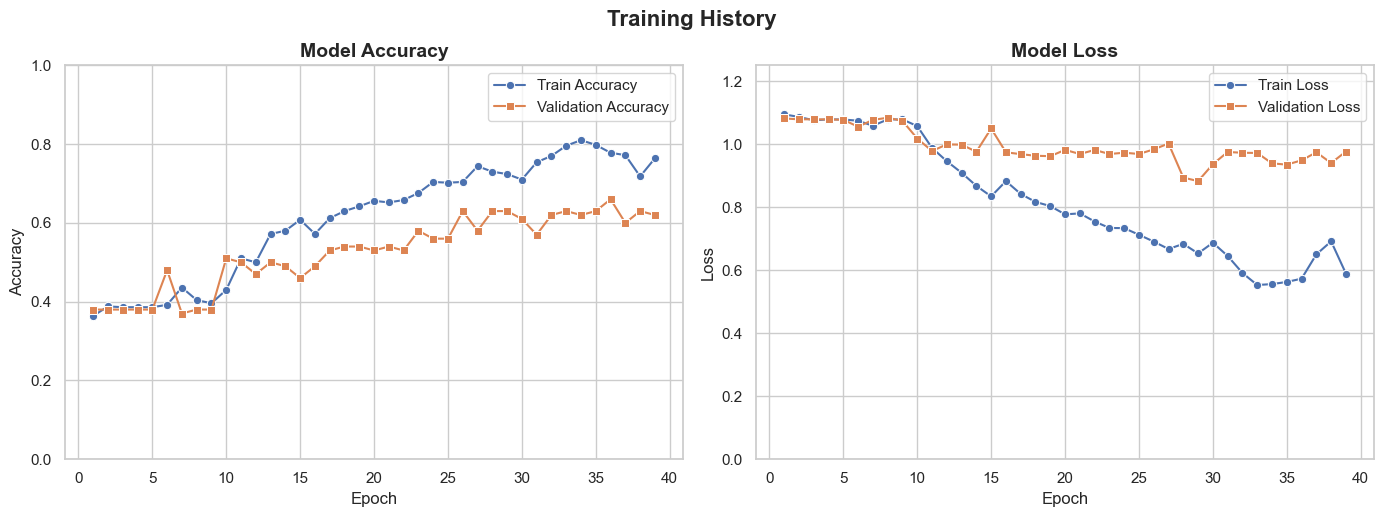

In [91]:
loss, accuracy = model_lstm_8_layers.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_8_layers.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_8_layers.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_8_layers.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [92]:
model_lstm_8_layers.save(f'models/lstm_model_8_layers.h5')

### Cells

#### 16 Cells LSTM

In [93]:
model_lstm_16_cells = Sequential()

model_lstm_16_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_16_cells.add(SpatialDropout1D(0.2))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16, return_sequences=True))
model_lstm_16_cells.add(LSTM(16))
model_lstm_16_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [94]:
model_lstm_16_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_16_cells = model_lstm_16_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.3570 - loss: 1.0962 - val_accuracy: 0.4100 - val_loss: 1.0889
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3988 - loss: 1.0840 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3889 - loss: 1.0713 - val_accuracy: 0.3800 - val_loss: 1.0770
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4044 - loss: 1.0651 - val_accuracy: 0.3800 - val_loss: 1.0743
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3917 - loss: 1.0620 - val_accuracy: 0.3800 - val_loss: 1.0652
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.3917 - loss: 1.0450 - val_accuracy: 0.4300 - val_loss: 1.0347
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4755 - loss: 1.0047 - val_accuracy: 0.5200 - val_loss: 1.0062
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5311 - loss: 0.9551 - val_accuracy: 0.4800 - val_loss: 0.9954

In [95]:
model_lstm_16_cells.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_11            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 100, 16)        │         7,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 100, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 100, 16)        │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,227 (1.23 MB)

 Trainable params: 13,875 (54.20 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 27,752 (108.41 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Validation Loss: 0.9895
Validation Accuracy: 0.5100
Validation Macro F1-score: 0.4935
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test Loss: 0.9296
Test Accuracy: 0.5600
Test Macro F1-score: 0.5501


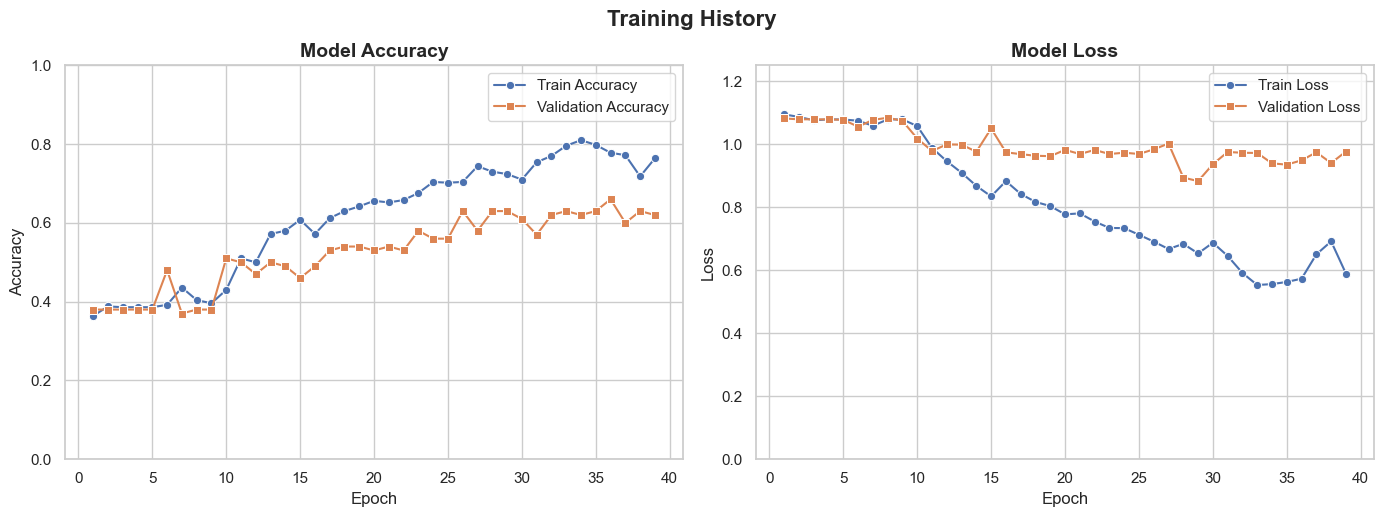

In [96]:
loss, accuracy = model_lstm_16_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_16_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_16_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_16_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [97]:
model_lstm_16_cells.save(f'models/lstm_model_16_cells.h5')

#### 64 Cells LSTM

In [98]:
model_lstm_64_cells = Sequential()

model_lstm_64_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_64_cells.add(SpatialDropout1D(0.2))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64, return_sequences=True))
model_lstm_64_cells.add(LSTM(64))
model_lstm_64_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [99]:
model_lstm_64_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_64_cells = model_lstm_64_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.3681 - loss: 1.0932 - val_accuracy: 0.4200 - val_loss: 1.0738
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4398 - loss: 1.0605 - val_accuracy: 0.5100 - val_loss: 1.0344
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5056 - loss: 1.0302 - val_accuracy: 0.5200 - val_loss: 1.0115
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5284 - loss: 0.9841 - val_accuracy: 0.4200 - val_loss: 1.0007
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4998 - loss: 0.9581 - val_accuracy: 0.4800 - val_loss: 0.9994
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5875 - loss: 0.8867 - val_accuracy: 0.4500 - val_loss: 1.0037
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5910 - loss: 0.8659 - val_accuracy: 0.5300 - val_loss: 0.9800
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5879 - loss: 0.8517 - val_accuracy: 0.5000 - val_loss:

In [100]:
model_lstm_64_cells.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,123 (2.69 MB)

 Trainable params: 141,507 (552.76 KB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 283,016 (1.08 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
Validation Loss: 0.9800
Validation Accuracy: 0.5300
Validation Macro F1-score: 0.5141
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Test Loss: 0.9427
Test Accuracy: 0.5400
Test Macro F1-score: 0.5254


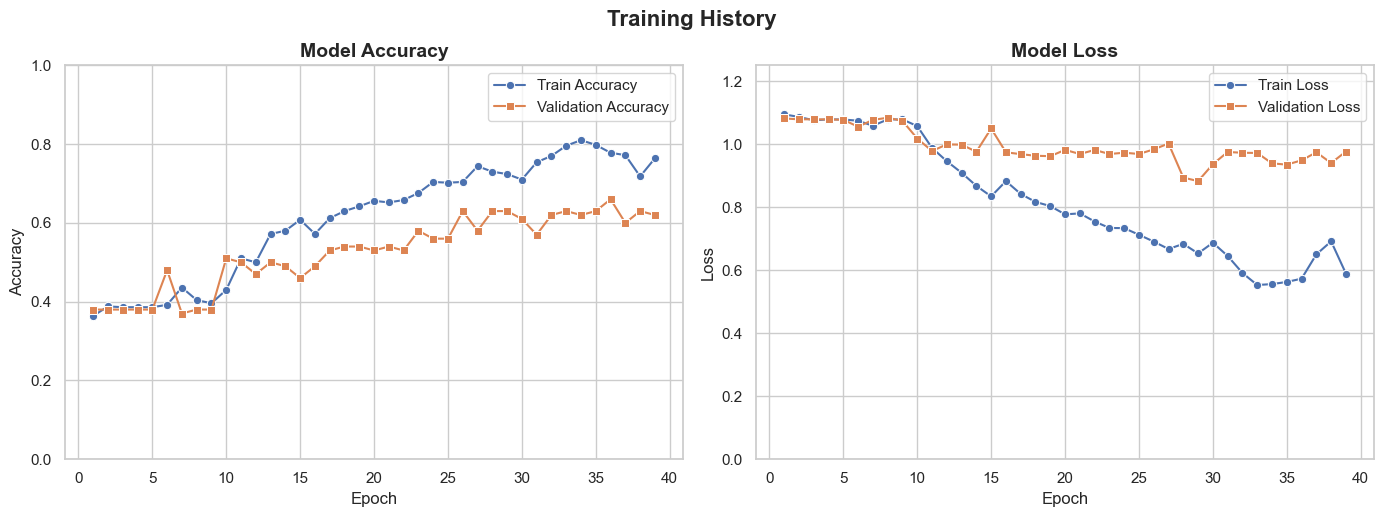

In [101]:
loss, accuracy = model_lstm_64_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_64_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_64_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_64_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [102]:
model_lstm_64_cells.save(f'models/lstm_model_64_cells.h5')

#### 128 Cells LSTM

In [103]:
model_lstm_128_cells = Sequential()

model_lstm_128_cells.add(Embedding(input_dim=actual_vocab_size,
                                      output_dim=embedding_dim,
                                      weights=[embedding_matrix],
                                      input_length=max_len,
                                      trainable=False))

model_lstm_128_cells.add(SpatialDropout1D(0.2))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128, return_sequences=True))
model_lstm_128_cells.add(LSTM(128))
model_lstm_128_cells.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [104]:
model_lstm_128_cells.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm_128_cells = model_lstm_128_cells.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.3660 - loss: 1.0898 - val_accuracy: 0.3900 - val_loss: 1.0660
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step - accuracy: 0.4689 - loss: 1.0403 - val_accuracy: 0.3300 - val_loss: 1.0617
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.3998 - loss: 1.0280 - val_accuracy: 0.4500 - val_loss: 0.9872
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.4710 - loss: 0.9751 - val_accuracy: 0.5100 - val_loss: 0.9800
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.5711 - loss: 0.8956 - val_accuracy: 0.4900 - val_loss: 0.9714
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.5886 - loss: 0.8651 - val_accuracy: 0.4900 - val_loss: 0.9654
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - accuracy: 0.5922 - loss: 0.8500 - val_accuracy: 0.4300 - val_loss: 1.0312
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.5611 - loss: 0.8954 - val_accuracy: 0.5000 - val_loss:

In [105]:
model_lstm_128_cells.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_13            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,763 (6.93 MB)

 Trainable params: 512,387 (1.95 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 1,024,776 (3.91 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Validation Loss: 0.8622
Validation Accuracy: 0.6600
Validation Macro F1-score: 0.6405
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Test Loss: 0.8920
Test Accuracy: 0.6525
Test Macro F1-score: 0.6369


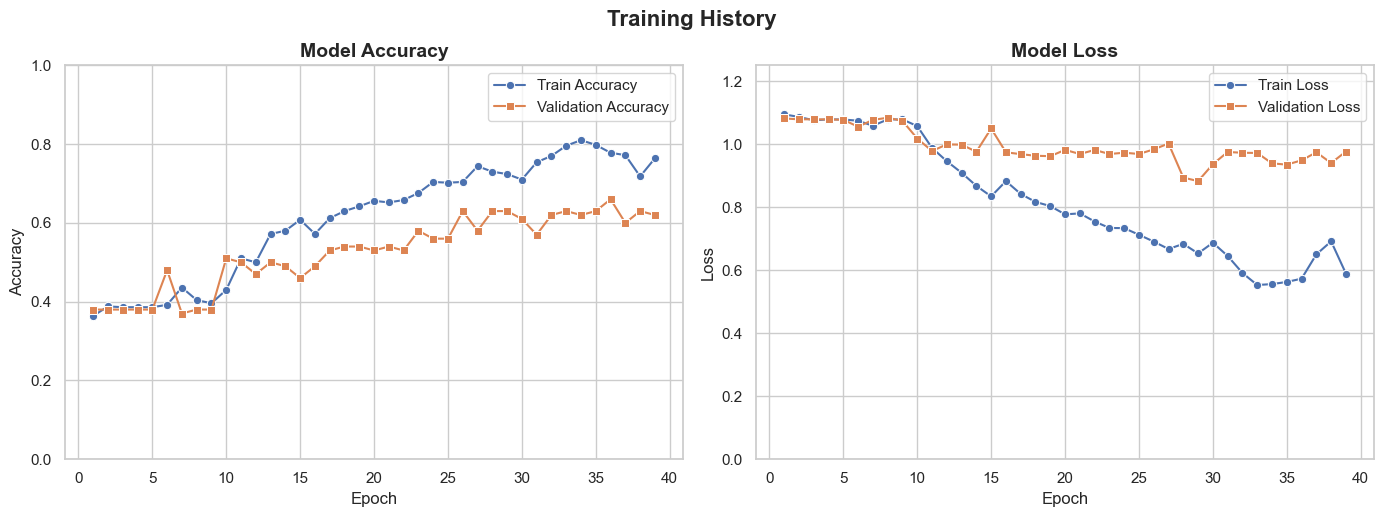

In [106]:
loss, accuracy = model_lstm_128_cells.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_128_cells.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_128_cells.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_128_cells.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [107]:
model_lstm_128_cells.save(f'models/lstm_model_128_cells.h5')

### Type

#### Unidirectional

In [108]:
model_lstm_unidirectional = Sequential()
model_lstm_unidirectional.add(Embedding(input_dim=actual_vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
model_lstm_unidirectional.add(SpatialDropout1D(0.2))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128, return_sequences=True))
model_lstm_unidirectional.add(LSTM(128))
model_lstm_unidirectional.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [109]:
model_lstm_unidirectional.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_uni = model_lstm_unidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.3462 - loss: 1.0922 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step - accuracy: 0.4111 - loss: 1.0838 - val_accuracy: 0.5200 - val_loss: 1.0222
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.4568 - loss: 1.0521 - val_accuracy: 0.4900 - val_loss: 1.0860
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.4307 - loss: 1.0817 - val_accuracy: 0.3800 - val_loss: 1.0657
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.4094 - loss: 1.0408 - val_accuracy: 0.4700 - val_loss: 1.0084
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.4760 - loss: 1.0595 - val_accuracy: 0.3700 - val_loss: 1.0410
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.4656 - loss: 1.0246 - val_accuracy: 0.4300 - val_loss: 1.0230
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 0.4991 - loss: 0.9800 - val_accuracy: 0.4400 - val_loss:

In [110]:
model_lstm_unidirectional.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_14            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,816,763 (6.93 MB)

 Trainable params: 512,387 (1.95 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 1,024,776 (3.91 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
Validation Loss: 0.8902
Validation Accuracy: 0.6100
Validation Macro F1-score: 0.5935
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Test Loss: 0.8671
Test Accuracy: 0.6250
Test Macro F1-score: 0.6190


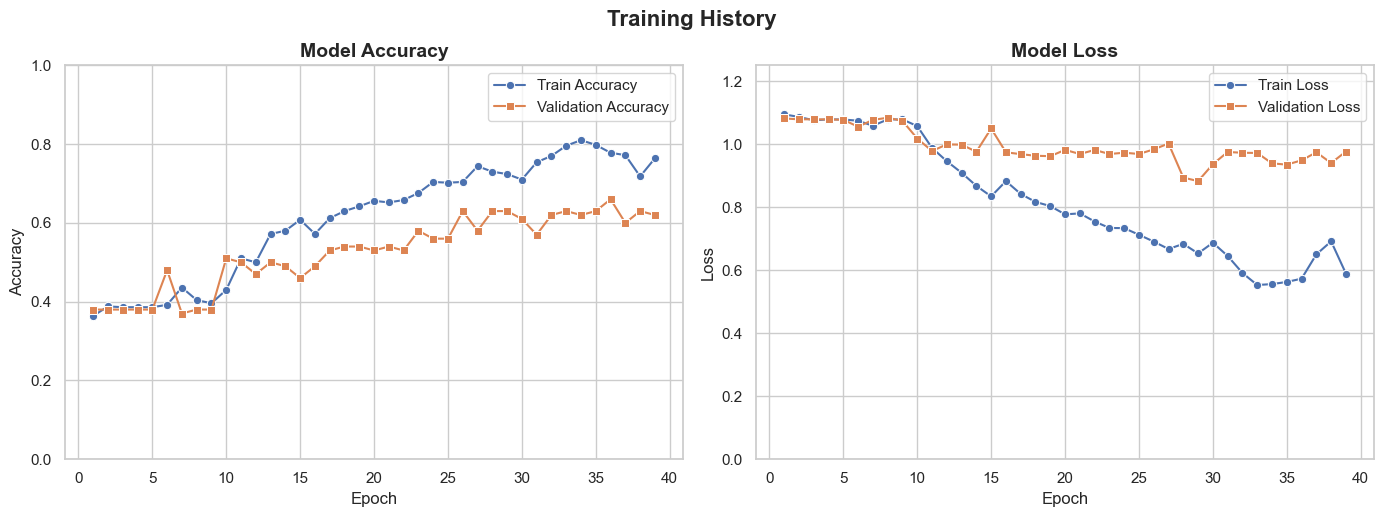

In [111]:
loss, accuracy = model_lstm_unidirectional.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_unidirectional.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_unidirectional.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_unidirectional.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [112]:
model_lstm_unidirectional.save(f'models/lstm_model_unidirectional.h5')

#### Bidirectional

In [113]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional

In [114]:
model_lstm_bidirectional = Sequential()
model_lstm_bidirectional.add(Embedding(input_dim=actual_vocab_size,
                       output_dim=embedding_dim,
                       weights=[embedding_matrix],
                       input_length=max_len,
                       trainable=False))
model_lstm_bidirectional.add(SpatialDropout1D(0.2))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidirectional.add(Bidirectional(LSTM(128)))
model_lstm_bidirectional.add(Dense(3, activation='softmax'))

c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [115]:
model_lstm_bidirectional.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bi = model_lstm_bidirectional.fit(X_train, y_train, epochs=EPOCH, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4386 - loss: 1.0387 - val_accuracy: 0.4600 - val_loss: 0.9916
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 980ms/step - accuracy: 0.5830 - loss: 0.8814 - val_accuracy: 0.5300 - val_loss: 0.9478
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6426 - loss: 0.7935 - val_accuracy: 0.6200 - val_loss: 0.9146
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 972ms/step - accuracy: 0.7013 - loss: 0.7039 - val_accuracy: 0.6000 - val_loss: 0.9208
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 971ms/step - accuracy: 0.7562 - loss: 0.6351 - val_accuracy: 0.6400 - val_loss: 0.8788
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 975ms/step - accuracy: 0.7614 - loss: 0.6073 - val_accuracy: 0.6500 - val_loss: 0.8821
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 986ms/step - accuracy: 0.7798 - loss: 0.5708 - val_accuracy: 0.6400 - val_loss: 0.9146
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 983ms/step - accuracy: 0.7872 - loss: 0.5893 - val_accuracy: 0.6100 - val_loss: 1.00

In [116]:
model_lstm_bidirectional.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 100)       │       279,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_15            │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,533,563 (17.29 MB)

 Trainable params: 1,417,987 (5.41 MB)

 Non-trainable params: 279,600 (1.07 MB)

 Optimizer params: 2,835,976 (10.82 MB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step
Validation Loss: 0.8788
Validation Accuracy: 0.6400
Validation Macro F1-score: 0.6181
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step
Test Loss: 0.8181
Test Accuracy: 0.6600
Test Macro F1-score: 0.6493


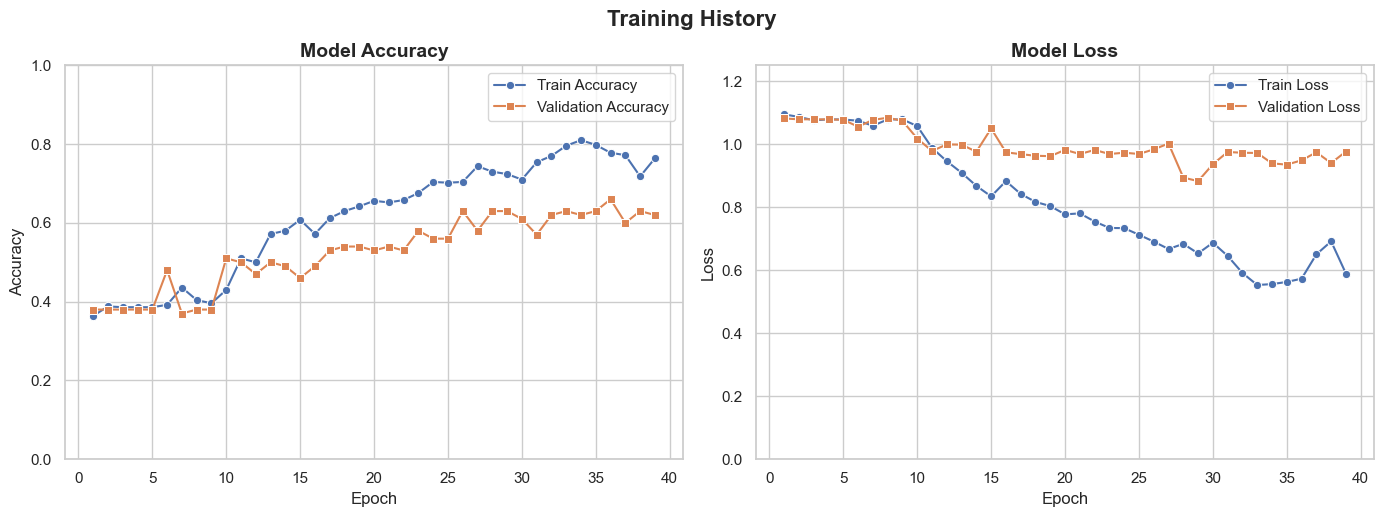

In [117]:
loss, accuracy = model_lstm_bidirectional.evaluate(X_val, y_val, verbose=0)
y_val_pred_prob = model_lstm_bidirectional.predict(X_val)
y_val_pred = y_val_pred_prob.argmax(axis=-1)
val_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Macro F1-score: {val_f1:.4f}')

X_test, y_test = df_test_preprocessed
loss_test, accuracy_test = model_lstm_bidirectional.evaluate(X_test, y_test, verbose=0)
y_test_pred_prob = model_lstm_bidirectional.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
test_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f'Test Loss: {loss_test:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Macro F1-score: {test_f1:.4f}')

plot_training_history(history_lstm_2_layers)

In [118]:
model_lstm_bidirectional.save(f'models/lstm_model_bidirectional.h5')

## LSTM FROM SCRATCH

In [121]:
batch_size = 100
seq_length = 20
vocab_size = 1000
num_classes = 3

lstm_model = LSTM_from_Scratch(
    embedding_dim=50,
    hidden_dim=64,
    num_classes=num_classes
)

history = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCH,
    learning_rate=0.01,
    batch_size=16,
    verbose=True
)

lstm_model.summary()

predictions = lstm_model.predict(X_train[:5])
probabilities = lstm_model.predict_proba(X_train[:5])

print(f"\nExample Predictions (first 5 sequences):")
print(f"Predictions: {predictions}")
print(f"True labels: {y_train[:5]}")
print(f"Accuracy: {lstm_model.score(X_train, y_train):.4f}")

print(f"\n" + "="*60)

Auto-detected vocabulary size: 999
Training LSTM Model
Data shape: X_train (100, 20), y_train (100,)
Model parameters: vocab_size=999, embedding_dim=50
                 hidden_dim=64, num_classes=3
Training parameters: epochs=50, lr=0.01, batch_size=16
Epoch   1/50 | Loss: 1.0972 | Train Acc: 0.4200
Epoch   3/50 | Loss: 1.0966
Epoch   5/50 | Loss: 1.0985
Epoch   6/50 | Loss: 1.0980 | Train Acc: 0.3900
Epoch   7/50 | Loss: 1.0990
Epoch   9/50 | Loss: 1.0961
Epoch  11/50 | Loss: 1.0975 | Train Acc: 0.4000
Epoch  13/50 | Loss: 1.0967
Epoch  15/50 | Loss: 1.0988
Epoch  16/50 | Loss: 1.0978 | Train Acc: 0.4000
Epoch  17/50 | Loss: 1.0971
Epoch  19/50 | Loss: 1.0986
Epoch  21/50 | Loss: 1.0981 | Train Acc: 0.4100
Epoch  23/50 | Loss: 1.0983
Epoch  25/50 | Loss: 1.0974
Epoch  26/50 | Loss: 1.0970 | Train Acc: 0.4300
Epoch  27/50 | Loss: 1.0964
Epoch  29/50 | Loss: 1.0983
Epoch  31/50 | Loss: 1.0974 | Train Acc: 0.4000
Epoch  33/50 | Loss: 1.0988
Epoch  35/50 | Loss: 1.0988
Epoch  36/50 | Loss